# Predicción de demanda


## Objetivo de esta etapa

En esta sección, me voy a enfocar en el desarrollo y puesta a punto de un modelo que pueda prever la demanda futura de consumo en el sistema de transporte público de Mar del Plata, utilizando técnicas de machine learning.

#### Recoleción de datos

Este conjunto de datos proviene de fuentes oficiales proporcionadas por el municipio de General Pueyrredón y el Ministerio de Transporte de la Nación, así como de los datos abiertos de la Nación Argentina. Los datos han sido recopilados de manera oficial y se utilizan con fines de análisis y evaluación. Los datos presentados aquí cumplen con los estándares de Protección de la Privacidad y Protección de la Propiedad Intelectual. No contienen información personal ni sensible de ningun tipo.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pointbiserialr
from statsmodels.formula.api import ols
import statsmodels.api as sm

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.model_selection import train_test_split

from datetime import datetime, timedelta
import holidays

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Datasets/sube-explored.csv')

Primero nos aseguramos que la columna DATE esta en el formato correcto:

In [3]:
df

,DATE,DAY,MONTH,YEAR,COMPANY,LINE_ID,TICKETS,DAY_OF_MONTH_SIN,DAY_OF_MONTH_COS,DAY_OF_WEEK,...,DAY_OF_YEAR_SIN,DAY_OF_YEAR_COS,WEEK_OF_YEAR,WEEK_OF_MONTH,MONTH_SIN,MONTH_COS,LAG_1,LAG_28,DAY_BEFORE_HOLIDAY,DAY_AFTER_HOLIDAY
0,2021-01-01,1,1,2021,25 DE MAYO,501,331,2.012985e-01,0.97953,5,...,1.721336e-02,0.999852,53,1,5.000000e-01,0.866025,3748,5212,False,False
1,2021-01-01,1,1,2021,PERALTA RAMOS,511,3869,2.012985e-01,0.97953,5,...,1.721336e-02,0.999852,53,1,5.000000e-01,0.866025,19956,29506,False,False
2,2021-01-01,1,1,2021,PERALTA RAMOS,512,1200,2.012985e-01,0.97953,5,...,1.721336e-02,0.999852,53,1,5.000000e-01,0.866025,6327,11046,False,False
3,2021-01-01,1,1,2021,25 DE MAYO,521,768,2.012985e-01,0.97953,5,...,1.721336e-02,0.999852,53,1,5.000000e-01,0.866025,4187,7984,False,False
4,2021-01-01,1,1,2021,25 DE MAYO,522,1158,2.012985e-01,0.97953,5,...,1.721336e-02,0.999852,53,1,5.000000e-01,0.866025,5726,11292,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29378,2023-12-31,31,12,2023,PERALTA RAMOS,581,4466,-2.449294e-16,1.00000,7,...,6.432491e-16,1.000000,52,5,-2.449294e-16,1.000000,6729,3638,True,False
29379,2023-12-31,31,12,2023,PERALTA RAMOS,591,2436,-2.449294e-16,1.00000,7,...,6.432491e-16,1.000000,52,5,-2.449294e-16,1.000000,6741,3641,True,False
29380,2023-12-31,31,12,2023,PERALTA RAMOS,593,2089,-2.449294e-16,1.00000,7,...,6.432491e-16,1.000000,52,5,-2.449294e-16,1.000000,3903,2721,True,False
29381,2023-12-31,31,12,2023,BATAN,715,2349,-2.449294e-16,1.00000,7,...,6.432491e-16,1.000000,52,5,-2.449294e-16,1.000000,5011,3452,True,False


Veamos las columnas disponibles:

In [4]:
df.columns

Index(['DATE', 'DAY', 'MONTH', 'YEAR', 'COMPANY', 'LINE_ID', 'TICKETS',
       'DAY_OF_MONTH_SIN', 'DAY_OF_MONTH_COS', 'DAY_OF_WEEK',
       'DAY_OF_WEEK_SIN', 'DAY_OF_WEEK_COS', 'HOLIDAY', 'WORKDAY', 'WEEKEND',
       'SEASON', 'DAY_OF_YEAR', 'DAY_OF_YEAR_SIN', 'DAY_OF_YEAR_COS',
       'WEEK_OF_YEAR', 'WEEK_OF_MONTH', 'MONTH_SIN', 'MONTH_COS', 'LAG_1',
       'LAG_28', 'DAY_BEFORE_HOLIDAY', 'DAY_AFTER_HOLIDAY'],
      dtype='object')

Para ordenar las pruebas de selección vamos a organizar las variables por su naturaleza:

In [5]:
categorical_vars = ['DAY', 'MONTH', 'YEAR', 'COMPANY', 'LINE_ID', 'DAY_OF_WEEK', 'SEASON', 
                    'DAY_OF_YEAR', 'WEEK_OF_YEAR', 'WEEK_OF_MONTH']

binary_vars = ['HOLIDAY', 'WORKDAY', 'WEEKEND', 'DAY_BEFORE_HOLIDAY', 'DAY_AFTER_HOLIDAY']

continuous_vars = ['TICKETS', 'DAY_OF_MONTH_SIN', 'DAY_OF_MONTH_COS', 'DAY_OF_WEEK_SIN', 
                   'DAY_OF_WEEK_COS', 'DAY_OF_YEAR_SIN', 'DAY_OF_YEAR_COS', 'MONTH_SIN', 'MONTH_COS', 
                   'LAG_1', 'LAG_28']

# Selección de variables

Teniendo en cuenta que tenemos delante un problema de regresión, naturalmente nuestra variable objetivo es continua. Vamos a analizar las variables categóricas contra nuestra variable objetivo. Para esto usaremos ANOVA:

In [6]:
anova_results = {}
for var in categorical_vars:
    formula = f'TICKETS ~ C({var})'
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_results[var] = anova_table

# Filtrar, ordenar por importancia basada en 'sum_sq' y filtrar por p-value < 0.05
anova_summary = pd.DataFrame({
    'Variable': anova_results.keys(),
    'Sum of Squares': [anova_results[var]['sum_sq'][0] for var in anova_results.keys()],
    'p-value': [anova_results[var]['PR(>F)'][0] for var in anova_results.keys()]
})

# Filtrar por p-value < 0.05
anova_summary = anova_summary[anova_summary['p-value'] < 0.05]

# Ordenar por 'Sum of Squares' y resetear el índice
anova_summary = anova_summary.sort_values(by='Sum of Squares', ascending=False).reset_index(drop=True)

# anova_summary = anova_summary.sort_values(by='Sum of Squares', ascending=False).reset_index(drop=True)
display(anova_summary)

,Variable,Sum of Squares,p-value
0,LINE_ID,4.573907e+11,0.000000e+00
1,DAY_OF_YEAR,9.598867e+10,0.000000e+00
2,DAY_OF_WEEK,6.523319e+10,0.000000e+00
3,COMPANY,4.891038e+10,0.000000e+00
4,YEAR,4.672396e+10,0.000000e+00
5,WEEK_OF_YEAR,1.398184e+10,3.192264e-83
6,MONTH,1.055897e+10,3.618974e-81
7,SEASON,6.190642e+09,7.631839e-53
8,DAY,2.978629e+09,6.474812e-12
9,WEEK_OF_MONTH,6.304079e+08,6.794055e-05


El análisis de varianza (ANOVA) realizado sobre las variables categóricas mostró que la variable más importante es `LINE_ID`, con la mayor suma de cuadrados (4.606005e+11) y un valor p extremadamente significativo (0.000000e+00), indicando que esta variable tiene el mayor impacto en la variabilidad de los tickets. Le siguen `DAY_OF_YEAR` y `DAY_OF_WEEK`, también con altos valores de suma de cuadrados (9.672552e+10 y 6.538796e+10, respectivamente) y valores p significativos (0.000000e+00), lo que muestra su relevancia en la explicación de la demanda. Otras variables importantes incluyen `COMPANY, YEAR, WEEK_OF_YEAR, y MONTH`, todas con valores p muy bajos y significativos, indicando que estas variables categóricas también contribuyen significativamente a la variabilidad de los tickets, aunque en menor medida que LINE_ID. 

Aquí me gustaria hacer una salvedad ya que `COMPANY` presenta discrepacias en sus datos, esto se debe a que en 2023 una empresa compró varias lineas de otra empresa, esto nos puede introducir valores erroneos.

Ahora vamos con Pearson para buscar correlaciones entre continuas:

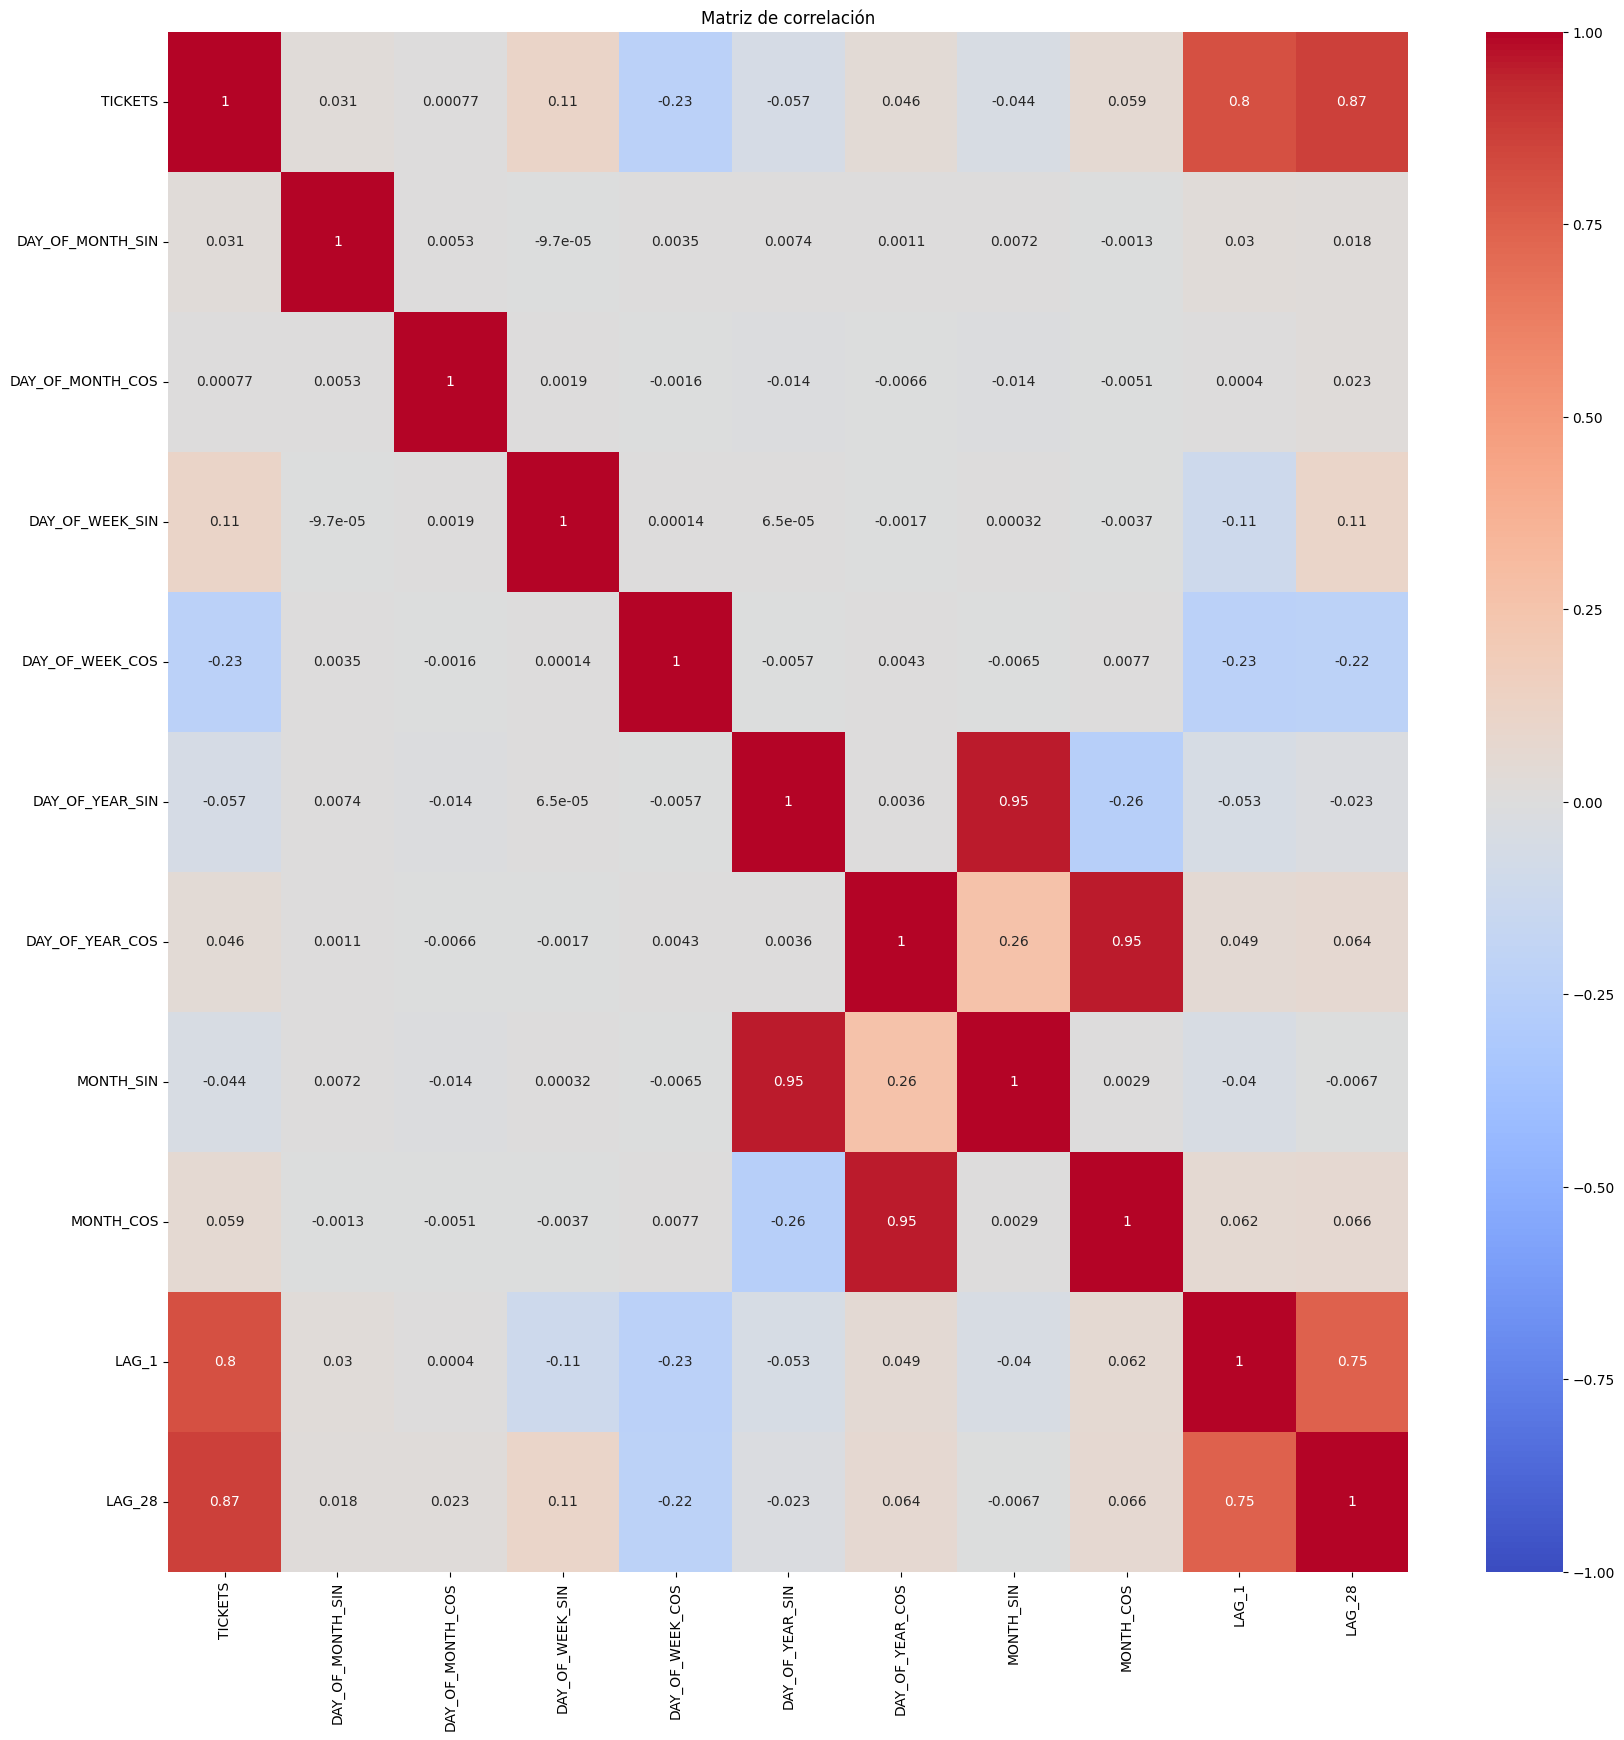

In [7]:
pearson_corr = df[continuous_vars].corr(method='pearson')
plt.figure(figsize=(20, 20))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de correlación')
plt.show()

Observando la matriz podemos afirmar que la caracteristica `LAG_1` u `LAG_28` que explican bien nuestra variable objetivo, si bien hay otros lags, estos se correlacionan entre si, para evitar esta redundancia los desestimamos. Por ultimo tendriamos `DAY_OF_WEEK_SIN` y `DAY_OF_WEEK_COS`, ambas tienen una correlación baja, y no se correlacionan entre si, la que menos correlacion tiene con `LAG_28` es `DAY_OF_WEEK_SIN`

Es el turno de Spearman, y a este le podemos sumar las variables oridinales en busca de captar relaciones no lineales:

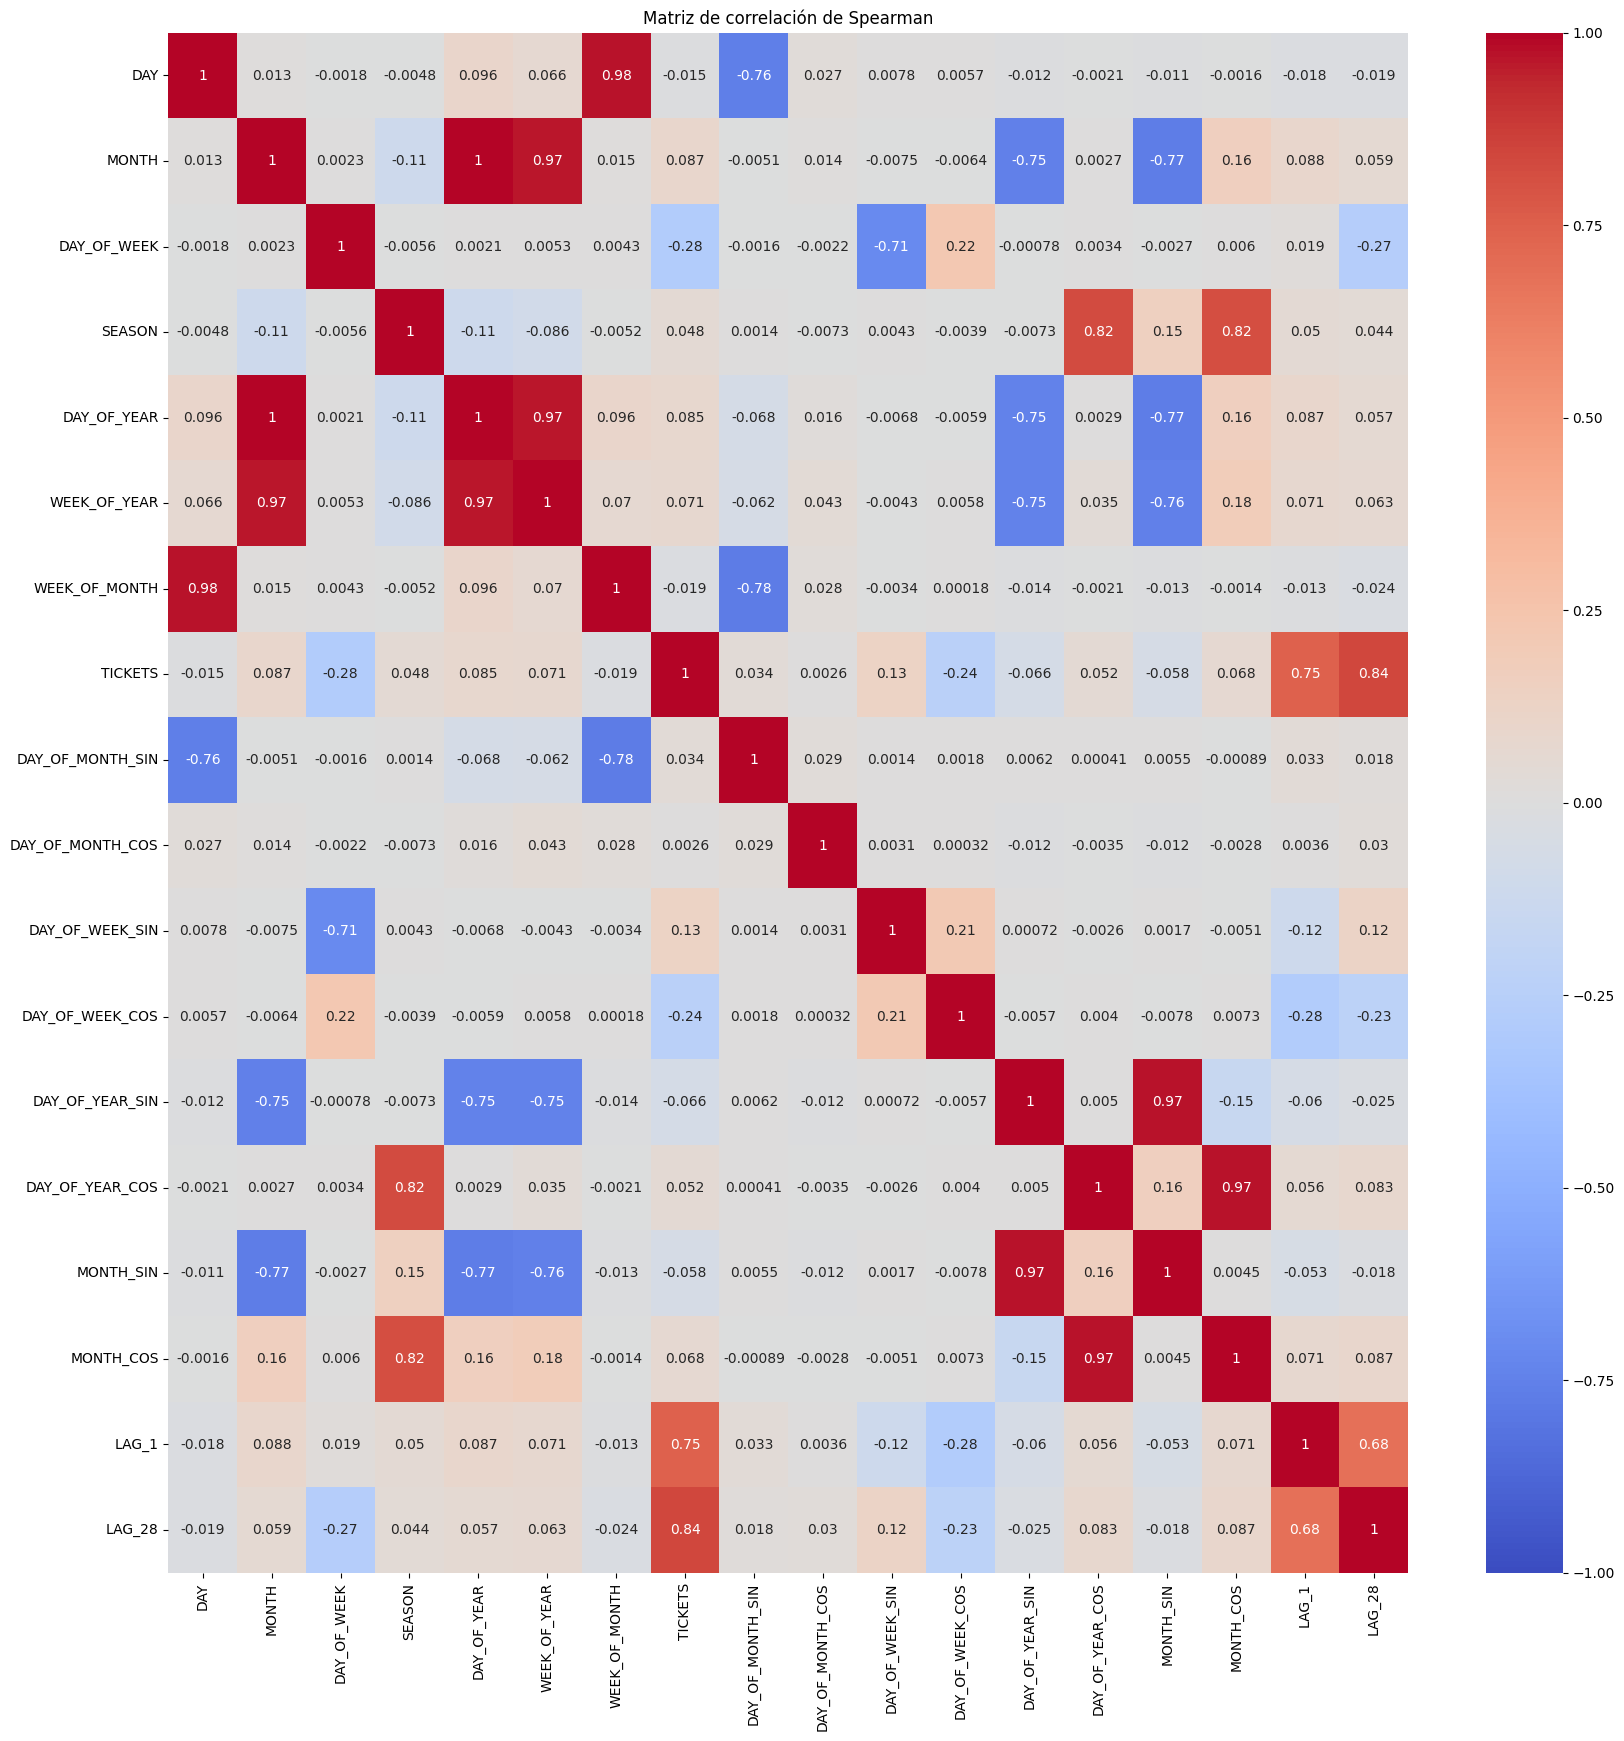

In [8]:
ordinal_vars = ['DAY', 'MONTH', 'DAY_OF_WEEK', 'SEASON', 'DAY_OF_YEAR', 'WEEK_OF_YEAR', 'WEEK_OF_MONTH']
ord_cont = ordinal_vars + continuous_vars
spearman_corr = df[ord_cont].corr(method='spearman')

plt.figure(figsize=(20, 20))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de correlación de Spearman')
plt.show()

Observamos con algo de correlación a `LAG_1` podria ir con `DAY_OF_WEEK`, podriamos probarla en lugar de `LAG_28` junto a `DAY_OF_YEAR_SIN`, pero no juntas.

Por ultimo hacemos un analsis biserial para nuestras variables de naturaleza binaria:

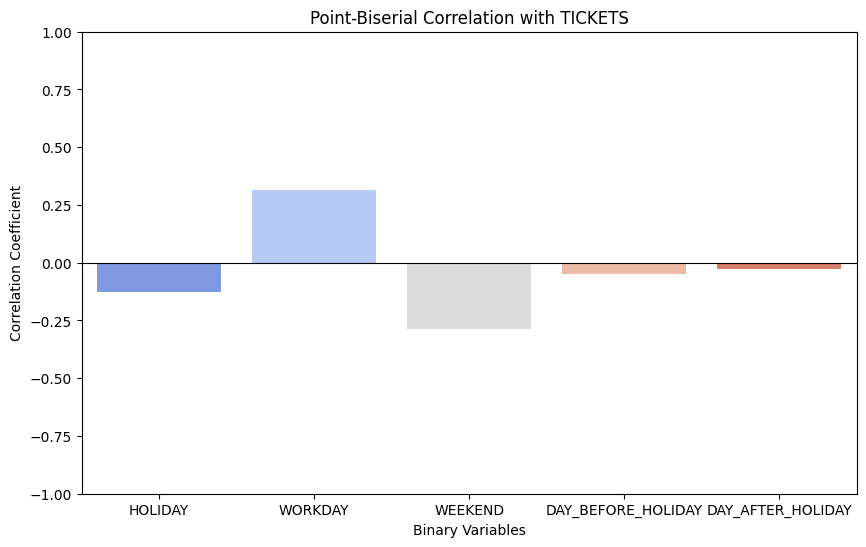

In [9]:
target_var = 'TICKETS'
correlations = {}

for var in binary_vars:
    corr, p_value = pointbiserialr(df[var], df[target_var])
    correlations[var] = corr

correlations_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])

plt.figure(figsize=(10, 6))
sns.barplot(x=correlations_df.index, y='Correlation', data=correlations_df, palette='coolwarm')
plt.title('Point-Biserial Correlation with TICKETS')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Binary Variables')
plt.ylim(-1, 1)
plt.axhline(0, color='black', linewidth=0.8)
plt.show()

De aqui observamos que `WORKDAY` y `WEEKEND` serian un buen punto de partida, anque al ser mutualmente excluyentes, nos quedamos con `WORKDAY`.

Hemos analizado todas las variables y su relevancia, comencemos con el modelado:

# Model: XGBoost

Elegí XGBoost para predecir la demanda de transporte debido a varias ventajas que considero importantes. En primer lugar, XGBoost es notablemente resistente a los outliers, una característica esencial dado que los datos de transporte contienen demandas significativas, mas que nada en verano, que podrían distorsionar los resultados en otros modelos. Además, XGBoost maneja eficazmente los valores faltantes, imputándolos durante el proceso de modelado. Otro aspecto destacable es su bajo costo computacional, ya que está diseñado para ser eficiente en términos de tiempo y recursos, permitiendo entrenar modelos complejos sin requerir un hardware excesivamente potente. La configuración inicial es relativamente sencilla y el algoritmo proporciona un equilibrio robusto entre rendimiento y facilidad de uso, permitiendo obtener resultados precisos sin necesidad de una extensa optimización de hiperparámetros. 

# División de datos

Luego de varias pruebas, he decidido dividir los datos el 31/10/2023 para entrenar mi serie temporal porque esta fecha permite capturar patrones y tendencias recientes, abarcando una estacionalidad anual completa hasta el punto de corte. Esta elección maximiza la cantidad de datos relevantes para el entrenamiento, mejorando la precisión del modelo al reflejar dinámicas actuales del sistema de transporte. Además, facilita una validación robusta con un conjunto de prueba reciente, garantizando que las predicciones sean fiables y aplicables en el futuro inmediato, equilibrando así la cantidad de datos históricos con la calidad de las predicciones a corto plazo. De esta manera evitamos introducir sesgo al modelo, garantizando que las pruebas siempre se predigan con datos pasados. 

Por otro lado, si bien disponemos del metodo TimeSeriesSplit este no es capaz de manejar fechas, lo que reflejaria un aplit menos puntual, y un posterior train / test con posible sesgo.

![split](img/split.png)

<!-- Grafico:
df = pd.read_csv('Datasets/sube-explored.csv')
df['DATE'] = pd.to_datetime(df['DATE'])

# Agrupar por día y sumar los tickets
daily_tickets = df.groupby('DATE')['TICKETS'].sum().reset_index()

# Crear el gráfico
plt.figure(figsize=(12, 3))

# Graficar los datos
plt.plot(daily_tickets['DATE'], daily_tickets['TICKETS'], label='Tickets diarios')

# Agregar línea vertical en la fecha especificada
cutoff_date = '2023-10-31'
plt.axvline(pd.to_datetime(cutoff_date), color='r', linestyle='--', label='Split')

# Añadir título y etiquetas
plt.title('Demanda diaria de transporte')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de tickets')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()
 -->

# Train / Test

Primero vamos a entrenar el modelo con los datos de 2021, 2022 y de 2023 solo hasta el 31 de octubre. La evaluación va a ser con el rango de fechas posteriores al 12 de octubre.

In [10]:
# Selección de características
X = df[['DAY_OF_WEEK_SIN', 'LINE_ID', 'WORKDAY', 'LAG_28', 'YEAR', 'DAY_OF_YEAR_SIN']].apply(pd.to_numeric)
y = df['TICKETS']

Ahora que tenemos definido y quiero hacer una prueba sobre la variable objetivo, y es evaluar si esta se beneficia de una transformacion logaritmica, ya que el rango de valores manejados es extenso, y los valores mas altos pueden estar muy alejados de la media:

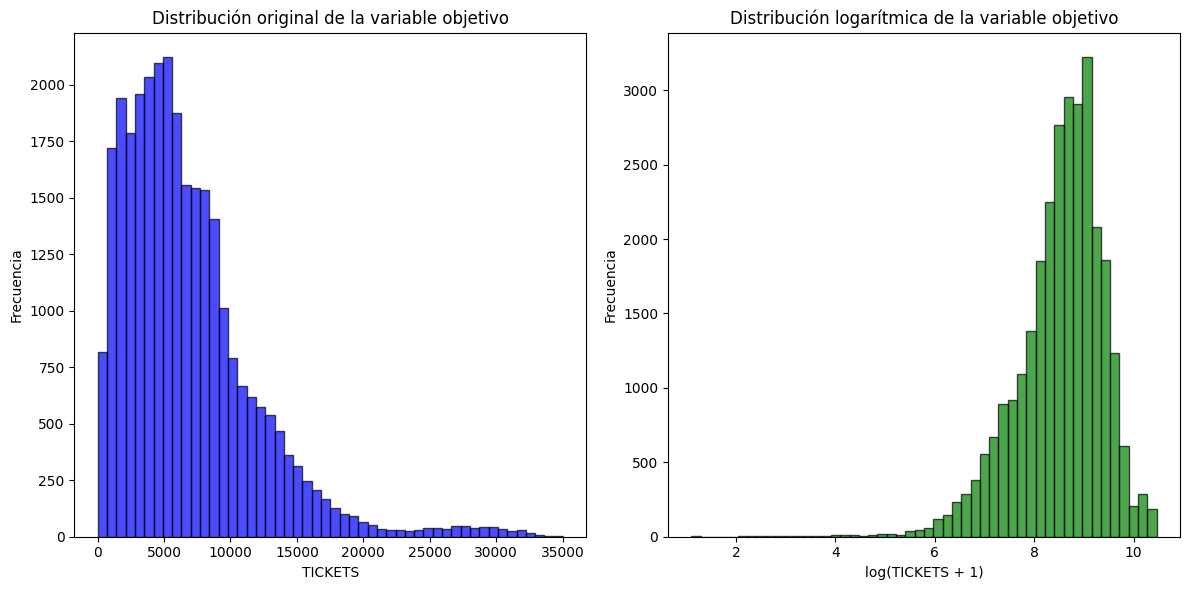

In [11]:
# Histograma de la variable objetivo original
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(y, bins=50, color='blue', edgecolor='k', alpha=0.7)
plt.title('Distribución original de la variable objetivo')
plt.xlabel('TICKETS')
plt.ylabel('Frecuencia')

# Histograma de la variable objetivo transformada logarítmicamente
plt.subplot(1, 2, 2)
plt.hist(np.log1p(y), bins=50, color='green', edgecolor='k', alpha=0.7)
plt.title('Distribución logarítmica de la variable objetivo')
plt.xlabel('log(TICKETS + 1)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

La transformación logarítmica de la variable objetivo puede mejorar significativamente el rendimiento del modelo al reducir la asimetría, manejar los valores anomalos, estabilizar la varianza y asegurar predicciones no negativas. Esto permite que el modelo capture mejor las relaciones subyacentes en los datos, resultando en predicciones más precisas y robustas.

Vamos con la primer prueba, generando un split de entrenamiento en una fecha cercana al dato mas reciente:

Mean Squared Error (XGBoost): 2842468.883291245
R^2 Score (XGBoost): 0.9138278961181641
Mean Absolute Error (XGBoost): 1173.511879942608
Root Mean Squared Error (XGBoost): 1685.9623018594589
Explained Variance Score (XGBoost): 0.9181894156927186


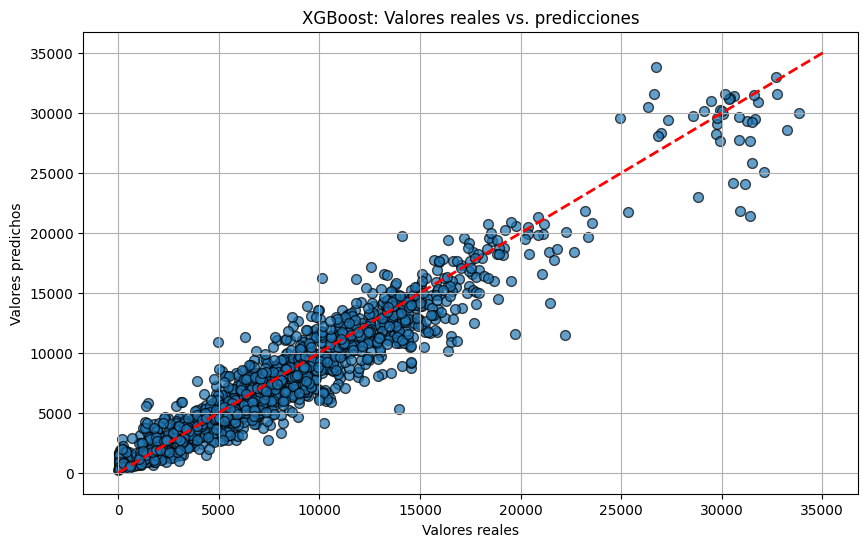

<Figure size 1000x600 with 0 Axes>

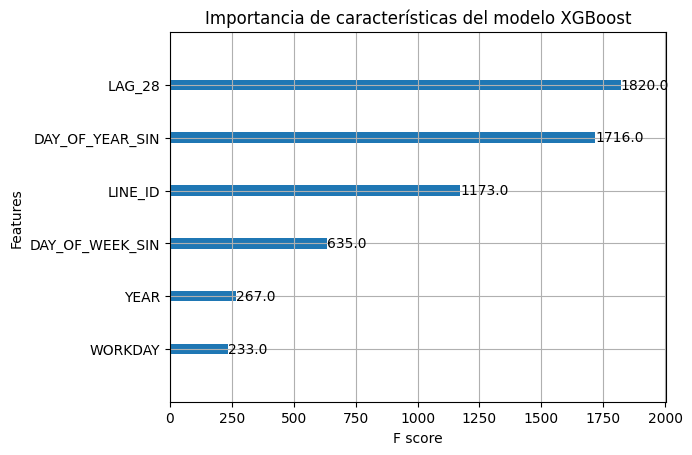

In [12]:
# Dividimos los datos en conjuntos de entrenamiento y prueba por fecha
train_start_date = '2022-01-01'
split = '2023-10-31'

# Creamos conjuntos de entrenamiento y prueba
X_train = X[(df['DATE'] >= train_start_date) & (df['DATE'] < split)]
X_test = X[df['DATE'] >= split]
y_train = y[(df['DATE'] >= train_start_date) & (df['DATE'] < split)]
y_test = y[df['DATE'] >= split]

# ==========================================================

y_train = np.log1p(y_train)

# Definimos el modelo
xgb_model_a = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model_a.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = xgb_model_a.predict(X_test)
y_pred = np.expm1(y_pred)

# ==========================================================

# Evaluamos resultados
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
explained_variance = explained_variance_score(y_test, y_pred)

print(f'Mean Squared Error (XGBoost): {mse}')
print(f'R^2 Score (XGBoost): {r2}')
print(f'Mean Absolute Error (XGBoost): {mae}')
print(f'Root Mean Squared Error (XGBoost): {rmse}')
print(f'Explained Variance Score (XGBoost): {explained_variance}')

# Graficamos
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7, s=50)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title('XGBoost: Valores reales vs. predicciones')
plt.grid(True)
plt.show()

# ==========================================================

from xgboost import plot_importance

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
plot_importance(xgb_model_a, importance_type='weight', max_num_features=10)
plt.title('Importancia de características del modelo XGBoost')
plt.show()

Por ultimo vamos a utilizar el modelo entrenado con toda la serie temporal:

In [13]:
# Definimos el modelo
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Podemos predecir 2024?

Para esto vamos a tener que generar las variables necesarias de entrada al modelo, tal como hicimos en la exploración anterior:

In [14]:
def get_lag_28_value(date, df_line):
    lag_28_date = date - timedelta(days=28)
    lag_28_value = df_line[df_line['DATE'] == lag_28_date]['TICKETS']
    
    if lag_28_value.empty:
        return None, lag_28_date  # O cualquier valor predeterminado que tenga sentido para tu caso
    else:
        return lag_28_value.values[0], lag_28_date

# ====================================================================

# Obtener feriados Argentina
ar_holidays = holidays.Argentina(years=[2024])

# Agregamos las fechas que faltan
manual_holidays = {
    '2024-03-28': "Jueves santo"
}
ar_holidays.update(manual_holidays)

# ====================================================================

# Definir la función que determina si una fecha es feriado
def is_holiday(date):
    return int(date in ar_holidays)

# Definir la función que determina si una fecha es un día hábil (workday)
def is_workday(date, day_of_week):
    return 1 if day_of_week in range(1, 6) and not is_holiday(date) else 0

Definimos la funcion que nos va a generar dia a dia, linea a linea la demanda:

Aquí se desarrolla un proceso de predicción diario para cada linea unica de finales de 2023, utilizando XGBoost y considerando características derivadas de la fecha, como el día de la semana y del año, y un valor de retraso de 28 días (lag_28). Solo se realizan predicciones cuando se es posible calcular todos los estimulos necesarios requeridos por el modelo, asegurando la calidad y consistencia de las predicciones. Por ultimo se registran las fechas omitidas por falta de dicha característica:

In [15]:
rows_with_missing = df[df.isna().any(axis=1)]
rows_with_missing

,DATE,DAY,MONTH,YEAR,COMPANY,LINE_ID,TICKETS,DAY_OF_MONTH_SIN,DAY_OF_MONTH_COS,DAY_OF_WEEK,...,DAY_OF_YEAR_SIN,DAY_OF_YEAR_COS,WEEK_OF_YEAR,WEEK_OF_MONTH,MONTH_SIN,MONTH_COS,LAG_1,LAG_28,DAY_BEFORE_HOLIDAY,DAY_AFTER_HOLIDAY


In [16]:
def generate_date_range(year):
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31)
    return pd.date_range(start_date, end_date).date

# ====================================================================

def generate_predictions(df, line_id, company, model, date_range):

    # Filtramos para la línea especificada
    df_line = df[df['LINE_ID'] == line_id].copy()
    df_line['DATE'] = pd.to_datetime(df_line['DATE']).dt.date
    df_line = df_line.sort_values(by='DATE')
    
    # Inicializamos una lista para almacenar las predicciones
    predictions = []
    omitions = []

    # Generamos la predicción para cada día
    for date in date_range:
        day_of_week = date.weekday() + 1
        day_of_year = date.timetuple().tm_yday
        
        workday = is_workday(date, day_of_week)
        lag_28, lag_28_date = get_lag_28_value(date, df_line)

        # Verificamos si LAG_28 existe
        if (lag_28 is not None):

            if lag_28 < 0:
                print(f'Lag_28 menor: [{lag_28}] - Fecha: {lag_28_date} - Linea: {line_id}')

            day_of_week_sin = np.sin(2 * np.pi * day_of_week / 7)
            day_of_year_sin = np.sin(2 * np.pi * day_of_year / 366) # Solo para 2024

            data = pd.DataFrame({
                'DAY_OF_WEEK_SIN': [day_of_week_sin],
                'LINE_ID': [line_id],
                'WORKDAY': [workday],
                'LAG_28': [lag_28],
                'YEAR': 2024,
                'DAY_OF_YEAR_SIN': [day_of_year_sin]
            })

            prediction = model.predict(data)
            prediction = prediction[0]
            prediction = round(prediction)

            if prediction >= 0:
                # Almacenamos la predicción con la fecha correspondiente
                predictions.append({
                    'DATE': date,
                    'DAY': date.day, 
                    'MONTH': date.month, 
                    'YEAR': date.year, 
                    'COMPANY': company,
                    'LINE_ID': line_id, 
                    'TICKETS': prediction
                })

                # Agregamos la predicción al DataFrame df_line
                new_row = pd.DataFrame({'DATE': [date], 'TICKETS': [prediction], 'LINE_ID': [line_id]})
                df_line = pd.concat([df_line, new_row], ignore_index=True)

            else:
                print(f'Prediccion negativa: [{prediction}] - Fecha: {date} | Lag: {lag_28} - Fecha lag: {lag_28_date}  - Linea: {line_id}')
        else:
            print(f'Lag_28 nulo: [{lag_28}] - Fecha: {lag_28_date} - Linea: {line_id}')

    # Convertimos las predicciones en DataFrame
    predictions_df = pd.DataFrame(predictions)
            
    return predictions_df

Ahora hacemos uso de las funciones y generamos las predicciones. Vale aclarar que para evitar el sesgo decidi no predecir las fechas que no tengan disponible la variable lag_28 debido a la importancia de esta caracteristica de entrada al modelo:

In [17]:
# Para todas las líneas
all_predictions = []

# Tomamos las lineas posteriores al 1/4 por la nueva organización de lineas
df_new_lines = df[df['DATE'] > '2023-04-01']
unique_line_company = df_new_lines[['LINE_ID', 'COMPANY']].drop_duplicates()

# ====================================================================

date_range = generate_date_range(2024)

for _, row in unique_line_company.iterrows():
    line_id = row['LINE_ID']
    company = row['COMPANY']
    pred_df = generate_predictions(df, line_id, company, xgb_model, date_range)
    if pred_df is not None:
        all_predictions.append(pred_df)

Prediccion negativa: [-143] - Fecha: 2024-05-01 | Lag: 1474 - Fecha lag: 2024-04-03  - Linea: 501
Lag_28 nulo: [None] - Fecha: 2024-05-01 - Linea: 501
Prediccion negativa: [-166] - Fecha: 2024-06-17 | Lag: 1193 - Fecha lag: 2024-05-20  - Linea: 501
Prediccion negativa: [-476] - Fecha: 2024-06-20 | Lag: 1353 - Fecha lag: 2024-05-23  - Linea: 501
Lag_28 nulo: [None] - Fecha: 2024-05-29 - Linea: 501
Prediccion negativa: [-66] - Fecha: 2024-07-07 | Lag: 1157 - Fecha lag: 2024-06-09  - Linea: 501
Lag_28 nulo: [None] - Fecha: 2024-06-17 - Linea: 501
Lag_28 nulo: [None] - Fecha: 2024-06-20 - Linea: 501
Lag_28 nulo: [None] - Fecha: 2024-06-26 - Linea: 501
Lag_28 nulo: [None] - Fecha: 2024-07-07 - Linea: 501
Prediccion negativa: [-393] - Fecha: 2024-08-11 | Lag: 356 - Fecha lag: 2024-07-14  - Linea: 501
Lag_28 nulo: [None] - Fecha: 2024-07-15 - Linea: 501
Lag_28 nulo: [None] - Fecha: 2024-07-18 - Linea: 501
Prediccion negativa: [-365] - Fecha: 2024-08-18 | Lag: 401 - Fecha lag: 2024-07-21  - Li

Combinamos todas las predicciones en un DataFrame:

In [18]:
combined_predictions_df = pd.concat(all_predictions)
combined_predictions_df = combined_predictions_df.sort_values(by=['YEAR', 'MONTH', 'DAY', 'LINE_ID'])
combined_predictions_df

,DATE,DAY,MONTH,YEAR,COMPANY,LINE_ID,TICKETS
0,2024-01-01,1,1,2024,PERALTA RAMOS,501,491
0,2024-01-01,1,1,2024,PERALTA RAMOS,511,12138
0,2024-01-01,1,1,2024,PERALTA RAMOS,512,1516
0,2024-01-01,1,1,2024,PERALTA RAMOS,521,3080
0,2024-01-01,1,1,2024,PERALTA RAMOS,522,3806
...,...,...,...,...,...,...,...
365,2024-12-31,31,12,2024,PERALTA RAMOS,581,6728
365,2024-12-31,31,12,2024,PERALTA RAMOS,591,7552
365,2024-12-31,31,12,2024,PERALTA RAMOS,593,4728
365,2024-12-31,31,12,2024,BATAN,715,6894


No se registraron las predicciones negativas:

In [20]:
combined_predictions_df[combined_predictions_df['TICKETS'] < 1]

,DATE,DAY,MONTH,YEAR,COMPANY,LINE_ID,TICKETS


In [21]:
combined_predictions_df[(combined_predictions_df['MONTH'] == 10) & (combined_predictions_df['DAY'] == 20) & (combined_predictions_df['LINE_ID'] == 543)]

,DATE,DAY,MONTH,YEAR,COMPANY,LINE_ID,TICKETS
293,2024-10-20,20,10,2024,PERALTA RAMOS,543,1235


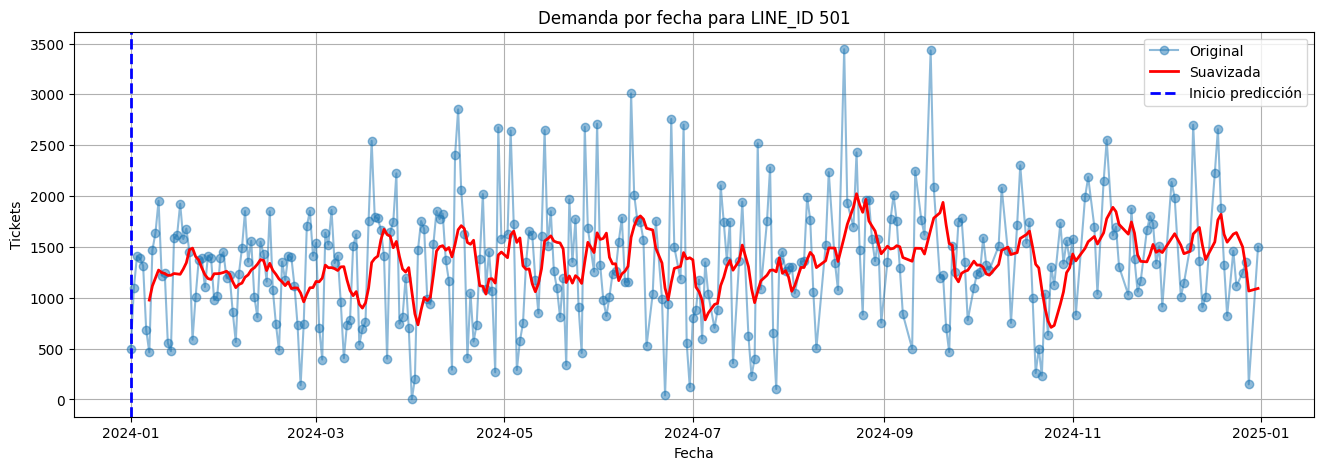

In [33]:
# Filtrar la información para la LINE_ID 501
df_filtered = combined_predictions_df[combined_predictions_df['LINE_ID'] == 501]

# Seleccionar las columnas necesarias
sel = ['TICKETS', 'DAY', 'MONTH', 'YEAR']
df_plot = df_filtered[sel].copy()
df_plot['DATE'] = pd.to_datetime(df_plot[['YEAR', 'MONTH', 'DAY']])

# Agrupar por fecha y sumar los tickets
df_plot = df_plot.groupby('DATE')['TICKETS'].sum().reset_index()

# Calcular la media móvil de 7 días
df_plot['TICKETS_SMOOTHED'] = df_plot['TICKETS'].rolling(window=7).mean()

# Graficar la serie temporal original y la suavizada
plt.figure(figsize=(16, 5))
plt.plot(df_plot['DATE'], df_plot['TICKETS'], marker='o', label='Original', alpha=0.5)
plt.plot(df_plot['DATE'], df_plot['TICKETS_SMOOTHED'], color='red', label='Suavizada', linewidth=2)

# Agregar línea vertical para el 1ro de enero de 2024
plt.axvline(pd.to_datetime('2024-01-01'), color='blue', linestyle='--', linewidth=2, label='Inicio predicción')

plt.title('Demanda por fecha para LINE_ID 501')
plt.xlabel('Fecha')
plt.ylabel('Tickets')
plt.grid(True)
plt.legend()
plt.show()

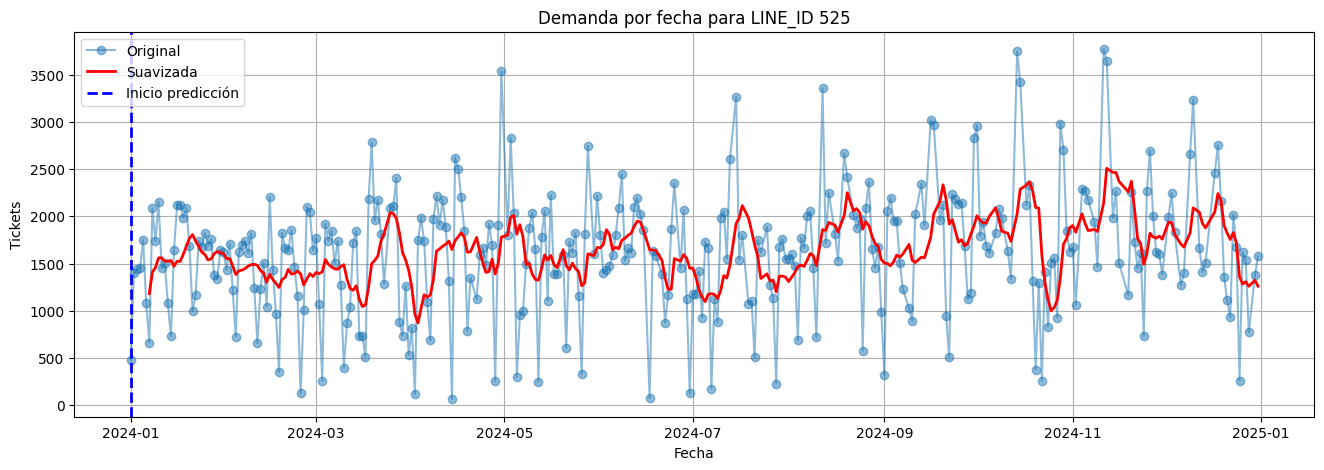

In [34]:
# Filtrar la información para la LINE_ID 525
df_filtered = combined_predictions_df[combined_predictions_df['LINE_ID'] == 525]

# Seleccionar las columnas necesarias
sel = ['TICKETS', 'DAY', 'MONTH', 'YEAR']
df_plot = df_filtered[sel].copy()
df_plot['DATE'] = pd.to_datetime(df_plot[['YEAR', 'MONTH', 'DAY']])

# Agrupar por fecha y sumar los tickets
df_plot = df_plot.groupby('DATE')['TICKETS'].sum().reset_index()

# Calcular la media móvil de 7 días
df_plot['TICKETS_SMOOTHED'] = df_plot['TICKETS'].rolling(window=7).mean()

# Graficar la serie temporal original y la suavizada
plt.figure(figsize=(16, 5))
plt.plot(df_plot['DATE'], df_plot['TICKETS'], marker='o', label='Original', alpha=0.5)
plt.plot(df_plot['DATE'], df_plot['TICKETS_SMOOTHED'], color='red', label='Suavizada', linewidth=2)

# Agregar línea vertical para el 1ro de enero de 2024
plt.axvline(pd.to_datetime('2024-01-01'), color='blue', linestyle='--', linewidth=2, label='Inicio predicción')

plt.title('Demanda por fecha para LINE_ID 525')
plt.xlabel('Fecha')
plt.ylabel('Tickets')
plt.grid(True)
plt.legend()
plt.show()

Combinamos con nuestro dataframe original:

In [23]:
# Traemos 2020
df_20 =  pd.read_csv('Datasets/sube-2020.csv')
df_20['DATE'] = pd.to_datetime(df_20['DATE'], format='%Y-%m-%d')
df_2020 = df_20[['DATE', 'DAY', 'MONTH', 'YEAR', 'COMPANY', 'LINE_ID', 'TICKETS']]
df_2020.head(10)

,DATE,DAY,MONTH,YEAR,COMPANY,LINE_ID,TICKETS
0,2020-01-01,1,1,2020,25 DE MAYO,501,315
1,2020-01-01,1,1,2020,PERALTA RAMOS,511,11463
2,2020-01-01,1,1,2020,PERALTA RAMOS,512,1889
3,2020-01-01,1,1,2020,25 DE MAYO,521,2729
4,2020-01-01,1,1,2020,25 DE MAYO,522,4010
5,2020-01-01,1,1,2020,25 DE MAYO,523,4791
6,2020-01-01,1,1,2020,25 DE MAYO,525,253
7,2020-01-01,1,1,2020,12 DE OCTUBRE,531,2339
8,2020-01-01,1,1,2020,12 DE OCTUBRE,532,1982
9,2020-01-01,1,1,2020,12 DE OCTUBRE,533,2425


In [26]:
df = df[['DATE', 'DAY', 'MONTH', 'YEAR', 'COMPANY', 'LINE_ID', 'TICKETS']]

df_20_23 = pd.concat([df, df_2020], axis=0)

df_full = pd.concat([df_20_23, combined_predictions_df], axis=0)
df_full['DATE'] = pd.to_datetime(df_full['DATE']).dt.date
df_full = df_full.sort_values(by=['YEAR', 'MONTH', 'DAY', 'LINE_ID'])
df_full = df_full.reset_index(drop=True)
df_full.tail(10)

,DATE,DAY,MONTH,YEAR,COMPANY,LINE_ID,TICKETS
48652,2024-12-31,31,12,2024,PERALTA RAMOS,555,7474
48653,2024-12-31,31,12,2024,12 DE OCTUBRE,562,14288
48654,2024-12-31,31,12,2024,12 DE OCTUBRE,563,11311
48655,2024-12-31,31,12,2024,PERALTA RAMOS,571,16821
48656,2024-12-31,31,12,2024,PERALTA RAMOS,573,11468
48657,2024-12-31,31,12,2024,PERALTA RAMOS,581,6728
48658,2024-12-31,31,12,2024,PERALTA RAMOS,591,7552
48659,2024-12-31,31,12,2024,PERALTA RAMOS,593,4728
48660,2024-12-31,31,12,2024,BATAN,715,6894
48661,2024-12-31,31,12,2024,PERALTA RAMOS,717,5857


Hagamos un analisis evaluatorio de la tendencia del modelo sobre los consumos agrupados por mes:

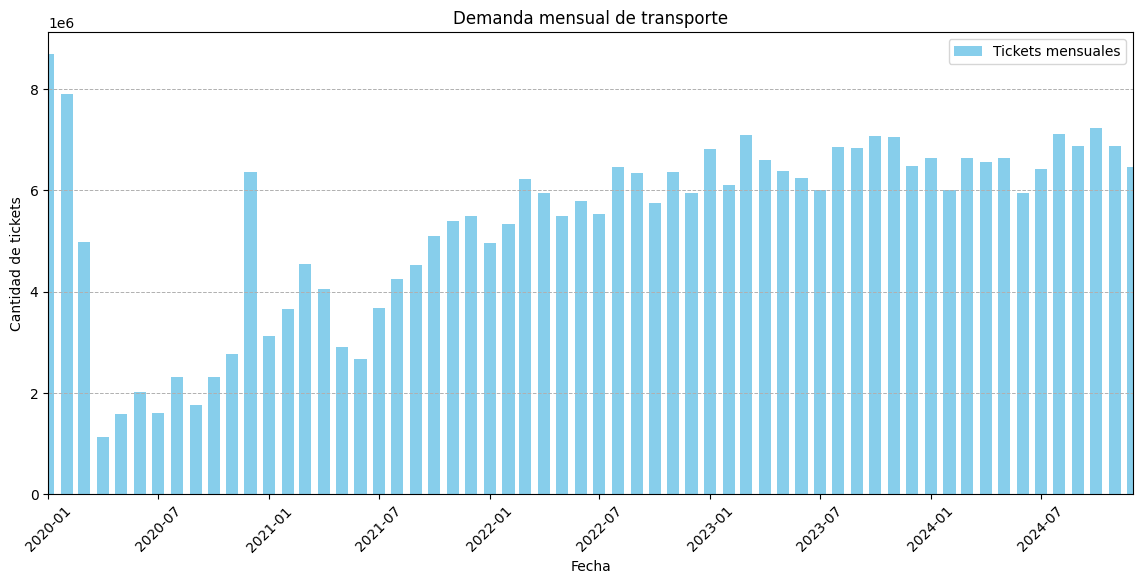

In [28]:
df_monthly = df_full.copy()

# Agrupar por año y mes y sumar los tickets
df_monthly['YEAR_MONTH'] = df_monthly['YEAR'].astype(str) + '-' + df_monthly['MONTH'].astype(str).str.zfill(2)
monthly_tickets = df_monthly.groupby('YEAR_MONTH')['TICKETS'].sum().reset_index()

# Convertir 'YEAR_MONTH' a datetime para ordenar correctamente en el gráfico
monthly_tickets['YEAR_MONTH'] = pd.to_datetime(monthly_tickets['YEAR_MONTH'], format='%Y-%m')

# Crear el gráfico
plt.figure(figsize=(14, 6))

# Ajustar el ancho de las barras
bar_width = 20

# Graficar los datos
plt.bar(monthly_tickets['YEAR_MONTH'], monthly_tickets['TICKETS'], label='Tickets mensuales', color='skyblue', width=bar_width)

# Añadir título y etiquetas
plt.title('Demanda mensual de transporte')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de tickets')
plt.legend()

# Ajustar los límites del eje x para mejorar la visualización
plt.xlim([monthly_tickets['YEAR_MONTH'].min(), monthly_tickets['YEAR_MONTH'].max()])

# Rotar etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.grid(True, axis='y', linestyle='--', linewidth=0.7)
plt.show()

Hagamos un analisis mas granular con una linea de transporte al azar:

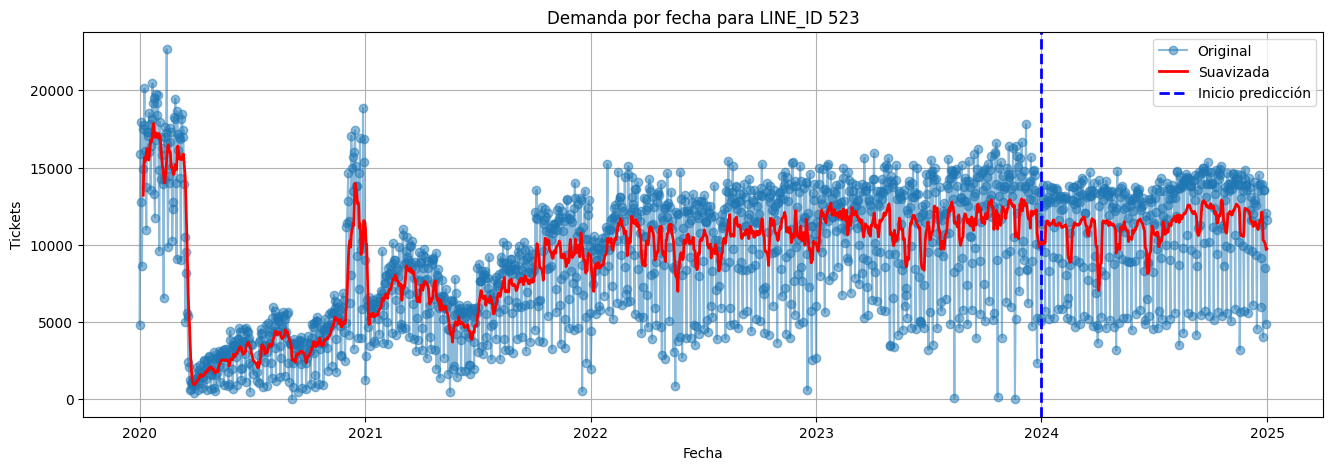

In [37]:
# Filtrar la información para la LINE_ID 523
df_filtered = df_full[df_full['LINE_ID'] == 523]

# Seleccionar las columnas necesarias
sel = ['TICKETS', 'DAY', 'MONTH', 'YEAR']
df_plot = df_filtered[sel].copy()
df_plot['DATE'] = pd.to_datetime(df_plot[['YEAR', 'MONTH', 'DAY']])

# Agrupar por fecha y sumar los tickets
df_plot = df_plot.groupby('DATE')['TICKETS'].sum().reset_index()

# Calcular la media móvil de 7 días
df_plot['TICKETS_SMOOTHED'] = df_plot['TICKETS'].rolling(window=7).mean()

# Graficar la serie temporal original y la suavizada
plt.figure(figsize=(16, 5))
plt.plot(df_plot['DATE'], df_plot['TICKETS'], marker='o', label='Original', alpha=0.5)
plt.plot(df_plot['DATE'], df_plot['TICKETS_SMOOTHED'], color='red', label='Suavizada', linewidth=2)

# Agregar línea vertical para el 1ro de enero de 2024
plt.axvline(pd.to_datetime('2024-01-01'), color='blue', linestyle='--', linewidth=2, label='Inicio predicción')

plt.title('Demanda por fecha para LINE_ID 523')
plt.xlabel('Fecha')
plt.ylabel('Tickets')
plt.grid(True)
plt.legend()
plt.show()

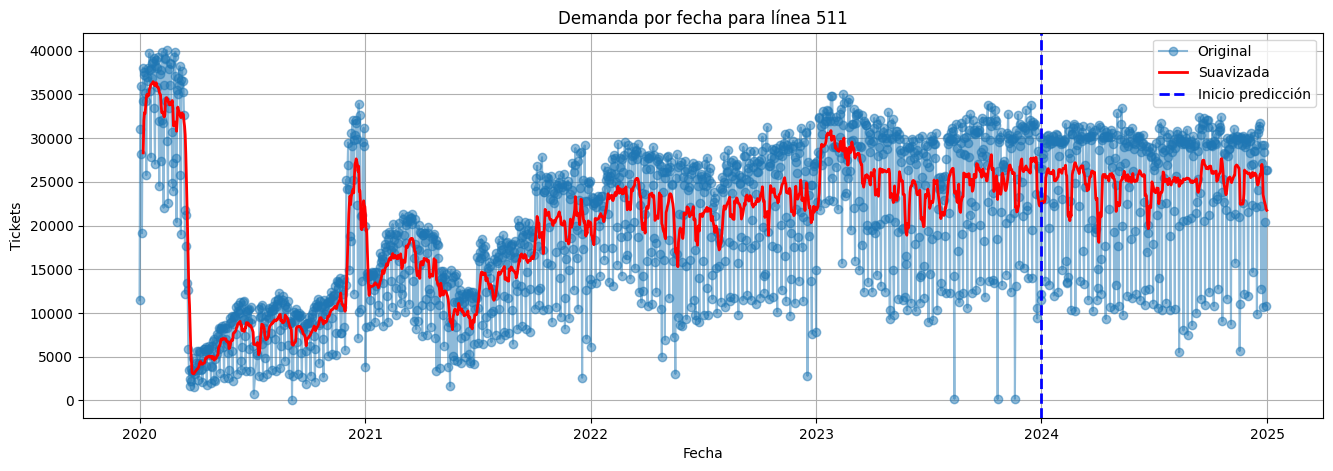

In [30]:
# Filtrar la información para la LINE_ID 501
df_filtered = df_full[df_full['LINE_ID'] == 511]

# Seleccionar las columnas necesarias
sel = ['TICKETS', 'DAY', 'MONTH', 'YEAR']
df_plot = df_filtered[sel].copy()
df_plot['DATE'] = pd.to_datetime(df_plot[['YEAR', 'MONTH', 'DAY']])

# Agrupar por fecha y sumar los tickets
df_plot = df_plot.groupby('DATE')['TICKETS'].sum().reset_index()

# Calcular la media móvil de 7 días
df_plot['TICKETS_SMOOTHED'] = df_plot['TICKETS'].rolling(window=7).mean()

# Graficar la serie temporal original y la suavizada
plt.figure(figsize=(16, 5))
plt.plot(df_plot['DATE'], df_plot['TICKETS'], marker='o', label='Original', alpha=0.5)
plt.plot(df_plot['DATE'], df_plot['TICKETS_SMOOTHED'], color='red', label='Suavizada', linewidth=2)

# Agregar línea vertical para el 1ro de enero de 2024
plt.axvline(pd.to_datetime('2024-01-01'), color='blue', linestyle='--', linewidth=2, label='Inicio predicción')

plt.title('Demanda por fecha para línea 511')
plt.xlabel('Fecha')
plt.ylabel('Tickets')
plt.grid(True)
plt.legend()
plt.show()

Por ultimo, veamos la serie temporal completa con suavizado:

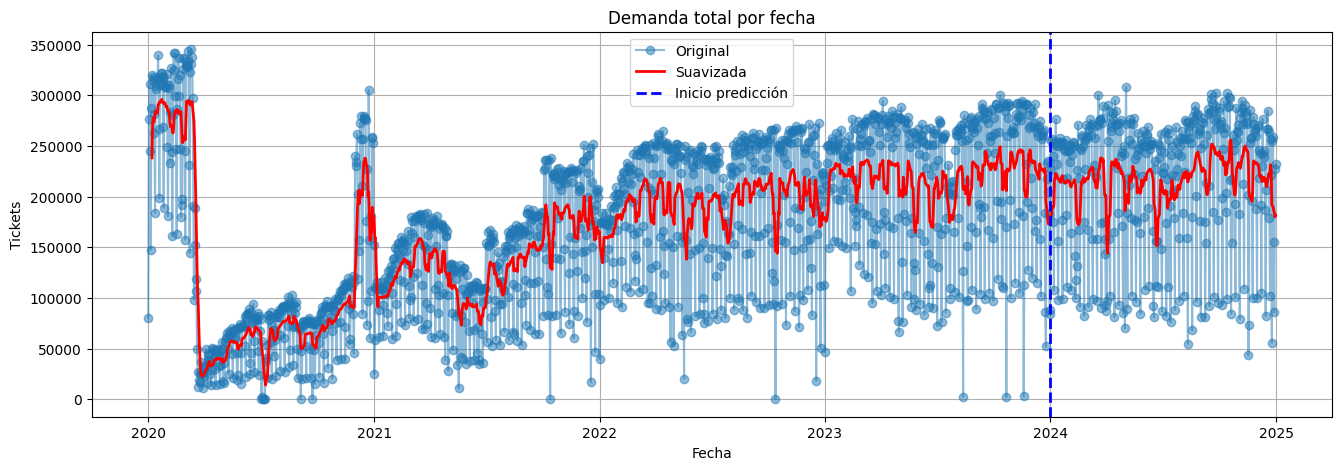

In [38]:
# Graficamos la informacion generada
sel = ['TICKETS', 'DAY', 'MONTH', 'YEAR']
df_plot = df_full[sel].copy()
df_plot['DATE'] = pd.to_datetime(df_plot[['YEAR', 'MONTH', 'DAY']])

# Agrupo por fecha y sumo los tickets
df_plot = df_plot.groupby('DATE')['TICKETS'].sum().reset_index()
df_plot['TICKETS_SMOOTHED'] = df_plot['TICKETS'].rolling(window=7).mean()

# Graficar la serie temporal original y la suavizada
plt.figure(figsize=(16, 5))
plt.plot(df_plot['DATE'], df_plot['TICKETS'], marker='o', label='Original', alpha=0.5)
plt.plot(df_plot['DATE'], df_plot['TICKETS_SMOOTHED'], color='red', label='Suavizada', linewidth=2)

# Agregar línea vertical para el 1ro de enero de 2024
plt.axvline(pd.to_datetime('2024-01-01'), color='blue', linestyle='--', linewidth=2, label='Inicio predicción')

plt.title('Demanda total por fecha')
plt.xlabel('Fecha')
plt.ylabel('Tickets')
plt.grid(True)
plt.legend()
plt.show()

Por ultimo guardamos el dataset para la exploración geográfica:

In [32]:
df_full.to_csv('Datasets/sube-with-predictions.csv', index=False)